In [25]:
import numpy as np
import zlib
import glob
import h5py
import pickle
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from generator_class_multi_1226 import DataGenerator
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
from pytictoc import TicToc

In [2]:
pixel_map_dir =  '/home/sophiaf/pixel_maps_val/pixel_data_subset/*.info'
_files = []
_files.extend(glob.glob(pixel_map_dir))

In [4]:
def load_data(file):
    '''
    If you already have the urls for the proper info loaded up in a pickle use this. 
    '''
    with open(file, 'rb') as f:
        mynewlist = pickle.load(f)
        f.close()
    return mynewlist

In [5]:
class DataGenerator2(keras.utils.Sequence):
    '''
    going to assume you've already preselected the energy ROI. 
    can run get_data if you haven't yet and save to pickle file the results. 
    '''
    
    def __init__(self, df, batch_size, dim, n_channels):
        # self.files = files
        self.df = df
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.t = TicToc()

    # __normalize__ method removed
    
    def get_info(self, file):
        with open(file, 'rb') as info_file:
            info = info_file.readlines()
            truth = {}
            truth['NuPDG'] = int(info[7].strip())
            truth['NuEnergy'] = float(info[1])
            truth['LepEnergy'] = float(info[2])
            truth['Interaction'] = int(info[0].strip()) % 4
            truth['NProton'] = int(info[8].strip())
            truth['NPion'] = int(info[9].strip())
            truth['NPizero'] = int(info[10].strip())  
            truth['NNeutron'] = int(info[11].strip())
            truth['is_antineutrino'] = int(int(info[7].strip())<0)
            truth['image_path'] = file[:-5] + '.gz'

            # extra labels for ML classification
            pdg = np.abs(truth['NuPDG'])
            if pdg == 1: truth['flavour'] = 0 #NC
            elif pdg == 12: truth['flavour'] = 1 #CC nu_e
            elif pdg == 14: truth['flavour'] = 2 #CC nu_mu
            elif pdg == 16: truth['flavour'] = 3 #CC nu_tau (not included in our E range but still here) 
            truth['protons'] = np.clip(truth['NProton'], None, 3) # 0,1,2,or N Protons 
            truth['pions'] = np.clip(truth['NPion'], None, 3) # 0,1,2,or N Pions 
            truth['pizeros'] = np.clip(truth['NPizero'], None, 3) # 0,1,2,or N Pizeros
            truth['neutrons'] = np.clip(truth['NNeutron'], None, 3) # 0,1,2,or N Neutrons 
            
        return truth
    
    def get_dataframe(self, files):
        data_labels = {}
        for i, file in enumerate(tqdm(files)):
            truth_info = self.get_info(file)
            if i==0:
                for key in truth_info.keys():
                    data_labels[key] = [truth_info[key]]
            else: 
                for key in truth_info.keys():
                    data_labels[key].append(truth_info[key])
        df = pd.DataFrame.from_dict(data_labels)
        return df

    def save_dataframe(self, df, path_to_df):
        pd.to_pickle(df, filepath_or_buffer=path_to_df)

    def load_dataframe(self, path_to_df, idx=None):
        df = pd.read_pickle(path_to_df)
        return df 
        
    def get_pixels_map(self, file_name):
        cells = self.dim[0]
        planes = self.dim[1]
        views = self.n_channels
        print('Opening file')
        self.t.tic()
        f = open(file_name, 'rb')
        self.t.toc()
        print('Reading file')
        self.t.tic()
        file = f.read()
        self.t.toc()
        print('Decompressing maps')
        self.t.tic()
        pixels_map = np.frombuffer(zlib.decompress(file), dtype=np.uint8)
        self.t.toc()
        print('Reshaping maps')
        self.t.tic()
        f.close()
        pixels_map = pixels_map.reshape(views, planes, cells)
        self.t.toc()
        return pixels_map
    
    def get_data_and_labels(self, idxs):
        data_subset = self.df.iloc[idxs]
        # data_subset = self.df.iloc[idxs[0]:idxs[1]]
        labels = ['flavour', 'protons', 'pions', 'pizeros', 'neutrons', 'is_antineutrino']
        data_label_dict = data_subset[labels]
        data_maps = []
        
        for file in data_subset['image_path']:
            data_maps.append(self.get_pixels_map(file))
        
        return data_maps, data_label_dict
    
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def __getitem__(self, index):
        upper_point = min((index + 1) * self.batch_size, len(self.df))
        indexes = list(range(index * self.batch_size, upper_point))
        # indexes = [index*self.batch_size, upper_point]
        # files_temp = [self.files[i] for i in indexes]

        maps_temp, labels_temp = self.get_data_and_labels(indexes)
        maps_z_view = np.asarray(maps_temp)[:, 2:]
        maps_v_view = np.asarray(maps_temp)[:, 1:2]
        maps_u_view = np.asarray(maps_temp)[:, 0:1]

        train_temp = []
        if self.n_channels == 1:
            for i in range(len(maps_z_view)):
                train_temp.append(maps_z_view[i][0])

        elif self.n_channels == 3:
            for i in range(len(maps_z_view)):
                train_temp.append(np.dstack((maps_u_view[i][0], maps_v_view[i][0], maps_z_view[i][0])))
        train_temp = np.array(train_temp).reshape([self.batch_size, self.dim[0], self.dim[1], self.n_channels])
        
        # labels_temp is a dictionary containing multiple output labels
        X, y = self.__data_generation(train_temp, labels_temp)
        return X, y
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.df))
    
    def __data_generation(self, train_temp, labels_temp):
        # Convert the labels_temp dictionary to a list of tensors
        y_list = [labels_temp[key] for key in labels_temp.keys()]
        return train_temp, y_list

In [5]:
import concurrent.futures


In [22]:
class DataGenerator2(keras.utils.Sequence):
    '''
    going to assume you've already preselected the energy ROI. 
    can run get_data if you haven't yet and save to pickle file the results. 
    '''
    
    def __init__(self, df, batch_size, dim, n_channels):
        # self.files = files
        self.df = df
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        # self.t = TicToc()

    # __normalize__ method removed
    
    def get_info(self, file):
        with open(file, 'rb') as info_file:
            info = info_file.readlines()
            truth = {}
            truth['NuPDG'] = int(info[7].strip())
            truth['NuEnergy'] = float(info[1])
            truth['LepEnergy'] = float(info[2])
            truth['Interaction'] = int(info[0].strip()) % 4 # if flavour >0: then interaction 0: 1: 2: 3: if flavour==0: interaction 1=NC. 
            truth['NProton'] = int(info[8].strip())
            truth['NPion'] = int(info[9].strip())
            truth['NPizero'] = int(info[10].strip())  
            truth['NNeutron'] = int(info[11].strip())
            truth['is_antineutrino'] = int(int(info[7].strip())<0)
            truth['LepAngle'] = float(info[15].strip())
            truth['image_path'] = file[:-5] + '.gz'
            
            truth['process'] = int(info[0].strip()) # https://github.com/DUNE/dunereco/blob/3430ba242903367ef06a8e37ff68119b9ef23656/dunereco/CVN/func/InteractionType.h#L16
            
            # extra labels for ML classification
            pdg = np.abs(truth['NuPDG'])
            if pdg == 1: truth['flavour'] = 0 #NC
            elif pdg == 12: truth['flavour'] = 1 #CC nu_e
            elif pdg == 14: truth['flavour'] = 2 #CC nu_mu
            elif pdg == 16: truth['flavour'] = 3 #CC nu_tau (not included in our E range but still here) 
            truth['protons'] = np.clip(truth['NProton'], None, 3) # 0,1,2,or N Protons 
            truth['pions'] = np.clip(truth['NPion'], None, 3) # 0,1,2,or N Pions 
            truth['pizeros'] = np.clip(truth['NPizero'], None, 3) # 0,1,2,or N Pizeros
            truth['neutrons'] = np.clip(truth['NNeutron'], None, 3) # 0,1,2,or N Neutrons 
            
        return truth
    
    def get_dataframe(self, files):
        data_labels = {}
        for i, file in enumerate(tqdm(files)):
            truth_info = self.get_info(file)
            # if 
            if i==0:
                for key in truth_info.keys():
                    data_labels[key] = [truth_info[key]]
            else: 
                for key in truth_info.keys():
                    data_labels[key].append(truth_info[key])
        df = pd.DataFrame.from_dict(data_labels)
        return df

    def save_dataframe(self, df, path_to_df):
        pd.to_pickle(df, filepath_or_buffer=path_to_df)

    def load_dataframe(self, path_to_df, idx=None):
        df = pd.read_pickle(path_to_df)
        return df 
        
    def get_pixels_map(self, file_name):
        cells = self.dim[0]
        planes = self.dim[1]
        views = self.n_channels
        # with open(file_name, 'rb') as f:
        f = open(file_name, 'rb')
        file = f.read()
        pixels_map = np.frombuffer(zlib.decompress(file), dtype=np.uint8)
        f.close()
        pixels_map = pixels_map.reshape(views, planes, cells)
        return pixels_map
    
    def get_data_and_labels(self, idxs):
        data_subset = self.df.iloc[idxs]
        # data_subset = self.df.iloc[idxs[0]:idxs[1]]
        labels = ['flavour', 'protons', 'pions', 'pizeros', 'neutrons', 'is_antineutrino']
        data_label_dict = data_subset[labels]
        data_maps = []
        
        # for file in data_subset['image_path']:
        #     data_maps.append(self.get_pixels_map(file))
        
        ## Use ThreadPoolExecutor for parallel file reading
        with concurrent.futures.ThreadPoolExecutor() as executor:
            # Map the file reading function to each file in parallel
            data_maps = list(executor.map(self.get_pixels_map, data_subset['image_path']))
        return data_maps, data_label_dict

    
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def __getitem__(self, index):
        upper_point = min((index + 1) * self.batch_size, len(self.df))
        indexes = list(range(index * self.batch_size, upper_point))
        # indexes = [index*self.batch_size, upper_point]
        # files_temp = [self.files[i] for i in indexes]

        maps_temp, labels_temp = self.get_data_and_labels(indexes)
        maps_z_view = np.asarray(maps_temp)[:, 2:]
        maps_v_view = np.asarray(maps_temp)[:, 1:2]
        maps_u_view = np.asarray(maps_temp)[:, 0:1]

        train_temp = []
        if self.n_channels == 1:
            for i in range(len(maps_z_view)):
                train_temp.append(maps_z_view[i][0])

        elif self.n_channels == 3:
            for i in range(len(maps_z_view)):
                train_temp.append(np.dstack((maps_u_view[i][0], maps_v_view[i][0], maps_z_view[i][0])))
        train_temp = np.array(train_temp).reshape([self.batch_size, self.dim[0], self.dim[1], self.n_channels])
        
        # labels_temp is a dictionary containing multiple output labels
        X, y = self.__data_generation(train_temp, labels_temp)
        return X, y
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.df))
    
    def __data_generation(self, train_temp, labels_temp):
        # Convert the labels_temp dictionary to a list of tensors
        y_list = [labels_temp[key] for key in labels_temp.keys()]
        return train_temp, y_list

## preprocessing

### Turning pixel file pointers to scratch path 

In [12]:
listname = 'urllist_0_1_2_10_11_12'
path_to_df = '/home/sophiaf/pixel_maps_val/preprocessed_filelists/'+listname+'_df.pkl'
path_to_test_df = '/home/sophiaf/pixel_maps_val/preprocessed_filelists/'+listname+'_df_testset.pkl'
df1 = pd.read_pickle(path_to_df)
df1_test = pd.read_pickle(path_to_test_df)

In [13]:
df1['image_path'] = df1['image_path'].str.replace('/home/sophiaf/pixel_maps_val/', '/scratch/7DayLifetime/sophiaf/')
df1_test['image_path'] = df1_test['image_path'].str.replace('/home/sophiaf/pixel_maps_val/', '/scratch/7DayLifetime/sophiaf/')


In [14]:
pd.to_pickle(df1_test, '/home/sophiaf/pixel_maps_val/preprocessed_filelists/scratch_'+listname+'_df_testset.pkl')
pd.to_pickle(df1, '/home/sophiaf/pixel_maps_val/preprocessed_filelists/scratch_'+listname+'_df.pkl')

### Making dfs  

In [11]:
listname = 'urllist_1' 
# data = load_data('/home/sophiaf/pixel_maps_val/preprocessed_filelists/'+listname+'.pkl')
testdata = load_data('/home/sophiaf/pixel_maps_val/preprocessed_filelists/'+listname+'_testset.pkl')
_files = testdata # bug
generator = DataGenerator2(_files,64,(200,200),3)


In [ ]:
path_to_df = '/home/sophiaf/pixel_maps_val/preprocessed_filelists/'+listname+'_df.pkl'
path_to_test_df = '/home/sophiaf/pixel_maps_val/preprocessed_filelists/'+listname+'_df_testset.pkl'
hi = generator.get_dataframe(data)
hi_test = generator.get_dataframe(testdata)

In [ ]:
listname = 'urllist_0_1_2_10_11_12'

data = load_data('/home/sophiaf/pixel_maps_val/preprocessed_filelists/'+listname+'.pkl')
testdata = load_data('/home/sophiaf/pixel_maps_val/preprocessed_filelists/'+listname+'_testset.pkl')
data_updated = [path.replace('/home/sophiaf/pixel_maps_val/', '/scratch/7DayLifetime/sophiaf/') for path in data]
testdata_updated = [path.replace('/home/sophiaf/pixel_maps_val/', '/scratch/7DayLifetime/sophiaf/') for path in testdata]

_files = data_updated # bug
generator = DataGenerator2(_files,64,(200,200),3)

path_to_test_df = '/home/sophiaf/pixel_maps_val/preprocessed_filelists/'+listname+'_b_df_testset.pkl'
hi_test = generator.get_dataframe(testdata_updated)
generator.save_dataframe(hi_test, path_to_test_df)

path_to_df = '/home/sophiaf/pixel_maps_val/preprocessed_filelists/'+listname+'_b_df.pkl'
hi = generator.get_dataframe(data_updated)
generator.save_dataframe(hi, path_to_df)

  4%|▍         | 5505/142324 [03:16<1:25:33, 26.65it/s] 

In [7]:
1

1

In [81]:
path_to_df = '/home/sophiaf/pixel_maps_val/preprocessed_filelists/'+listname+'_df.pkl'
path_to_test_df = '/home/sophiaf/pixel_maps_val/preprocessed_filelists/'+listname+'_df_testset.pkl'
hi = generator.get_dataframe(data)
hi_test = generator.get_dataframe(testdata)

100%|██████████| 8863/8863 [00:38<00:00, 227.97it/s]


In [82]:
generator.save_dataframe(hi, path_to_df)
generator.save_dataframe(hi_test, path_to_test_df)


In [85]:
listname = 'urllist_2' 
data = load_data('/home/sophiaf/pixel_maps_val/preprocessed_filelists/'+listname+'.pkl')
testdata = load_data('/home/sophiaf/pixel_maps_val/preprocessed_filelists/'+listname+'_testset.pkl')
_files = data # bug
# generator = DataGenerator2(_files,64,(200,200),3)


In [86]:
path_to_df = '/home/sophiaf/pixel_maps_val/preprocessed_filelists/'+listname+'_df.pkl'
path_to_test_df = '/home/sophiaf/pixel_maps_val/preprocessed_filelists/'+listname+'_df_testset.pkl'
hi = generator.get_dataframe(data)
hi_test = generator.get_dataframe(testdata)

100%|██████████| 35850/35850 [03:01<00:00, 197.80it/s]


In [87]:
generator.save_dataframe(hi, path_to_df)
generator.save_dataframe(hi_test, path_to_test_df)

In [89]:
list_of_files = ['urllist_0', 'urllist_1', 'urllist_2']

list_of_locs = ['/home/sophiaf/pixel_maps_val/preprocessed_filelists/'+listname+'_df.pkl' for listname in list_of_files]
df_0_1_2 = pd.concat(pd.read_pickle(f) for f in list_of_locs)
pd.to_pickle(df_0_1_2, filepath_or_buffer='/home/sophiaf/pixel_maps_val/preprocessed_filelists/urllist_0_1_2_df.pkl')

list_of_test_locs = ['/home/sophiaf/pixel_maps_val/preprocessed_filelists/'+listname+'_df_testset.pkl' for listname in list_of_files]
df_0_1_2_testset = pd.concat(pd.read_pickle(f) for f in list_of_test_locs)
pd.to_pickle(df_0_1_2_testset, filepath_or_buffer='/home/sophiaf/pixel_maps_val/preprocessed_filelists/urllist_0_1_2_df_testset.pkl')



In [5]:
listname = 'urllist_10_12' 
data = load_data('/home/sophiaf/pixel_maps_val/preprocessed_filelists/'+listname+'.pkl')
testdata = load_data('/home/sophiaf/pixel_maps_val/preprocessed_filelists/'+listname+'_testset.pkl')
_files = data # bug
generator = DataGenerator2(_files,64,(200,200),3)


In [5]:
path_to_df = '/home/sophiaf/pixel_maps_val/preprocessed_filelists/'+listname+'_df.pkl'
hi = generator.get_dataframe(data)
generator.save_dataframe(hi, path_to_df)

 37%|███▋      | 268782/723833 [2:50:49<8:02:43, 15.71it/s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

 84%|████████▍ | 607865/723833 [8:48:32<3:29:50,  9.21it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
path_to_test_df = '/home/sophiaf/pixel_maps_val/preprocessed_filelists/'+listname+'_df_testset.pkl'
hi_test = generator.get_dataframe(testdata)
generator.save_dataframe(hi_test, path_to_test_df)

  3%|▎         | 2785/80426 [02:25<50:30, 25.62it/s]  

In [11]:
list_of_files = ['urllist_0_1_2', 'urllist_10_12']

list_of_locs = ['/home/sophiaf/pixel_maps_val/preprocessed_filelists/'+listname+'_df.pkl' for listname in list_of_files]
df_0_1_2 = pd.concat(pd.read_pickle(f) for f in list_of_locs)
pd.to_pickle(df_0_1_2, filepath_or_buffer='/home/sophiaf/pixel_maps_val/preprocessed_filelists/urllist_0_1_2_10_11_12_df.pkl')

list_of_test_locs = ['/home/sophiaf/pixel_maps_val/preprocessed_filelists/'+listname+'_df_testset.pkl' for listname in list_of_files]
df_0_1_2_testset = pd.concat(pd.read_pickle(f) for f in list_of_test_locs)
pd.to_pickle(df_0_1_2_testset, filepath_or_buffer='/home/sophiaf/pixel_maps_val/preprocessed_filelists/urllist_0_1_2_10_11_12_df_testset.pkl')

## testing

In [43]:
path_to_df = '/home/sophiaf/pixel_maps_val/preprocessed_filelists/urllist_2_df.pkl'
df = pd.read_pickle(path_to_df)
generator = DataGenerator2(df, 64, (200,200), 3)

In [45]:
import os
import shutil

def split_files(input_dir, output_dir, batch_size):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    file_list = sorted(os.listdir(input_dir))
    num_batches = len(file_list) // batch_size

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size
        subset_dir = os.path.join(output_dir, f'subset_{i + 1}')

        if not os.path.exists(subset_dir):
            os.makedirs(subset_dir)

        for file_name in file_list[start_idx:end_idx]:
            if file_name.endswith('.gz'):
                source_path = os.path.join(input_dir, file_name)
                dest_path = os.path.join(subset_dir, file_name)
                shutil.move(source_path, dest_path)

In [46]:
listname = 'subset' 
data = load_data('/home/sophiaf/pixel_maps_val/preprocessed_filelists/'+listname+'.pkl')
testdata = load_data('/home/sophiaf/pixel_maps_val/preprocessed_filelists/'+listname+'_testset.pkl')
_files = data # bug
# generator = DataGenerator2(_files,64,(200,200),3)

In [47]:
path_to_df = '/home/sophiaf/pixel_maps_val/preprocessed_filelists/'+listname+'_df.pkl'
path_to_test_df = '/home/sophiaf/pixel_maps_val/preprocessed_filelists/'+listname+'_df_testset.pkl'
hi = generator.get_dataframe(data)
hi_test = generator.get_dataframe(testdata)

100%|██████████| 7/7 [00:00<00:00, 385.49it/s]


In [42]:
oldgenerator = DataGenerator(_files, 64, (200,200), 3)

In [44]:
%%time
a, b = oldgenerator.__getitem__(3)

CPU times: user 29.7 ms, sys: 210 ms, total: 239 ms
Wall time: 442 ms


In [8]:
hi = generator.load_dataframe(path_to_df)

In [12]:
index=0
indexes = list(range(index * 64, (index + 1) * 64))

## Preprocess into file lists that are <4 GeV 

In [ ]:
def get_data(pixel_map_dir, generator):
    '''
    Get pixels maps 
    '''
    file_list_all = glob.glob(pixel_map_dir)
    file_list = []

    for f in file_list_all:
        if generator.get_info(f)['NuPDG'] != 16 and generator.get_info(f)['NuPDG'] != -16 and generator.get_info(f)['NuEnergy'] < 4.0:
            file_list.append(f)

    random.shuffle(file_list)
    split = int(.9*len(file_list)) # 10% for testing
    allfiles, testfiles = file_list[:split], file_list[split:]
    
    return allfiles, testfiles

I unfortunately lost this code, but the code was to run that on the whole directory, get a list, then save it as a pickle. Then I concatenated the lists using .extend() to save combined directories. 

In [ ]:
# Essenially (here's the pseudo-code) 
_files = glob.glob(directory/*.info)
generator = DataGenerator2(_files,64,(200,200),3)

dat, testdat = get_data(_files, generator)
pickle.save(dat, loc.pkl)
pickle.save(testdat, loc_test.pkl) 

# then load them up to merge if doing this on multiple directories 
a = pickle.load(loc.pkl)
b = pickle.load(loc2.pkl) 
c = a.extend(b)
pickle.save(c, a_b.pkl)

## Looking at df 

In [42]:
listname = 'urllist_0_1_2_10_11_12'
df = pd.read_pickle('/home/sophiaf/pixel_maps_val/preprocessed_filelists/scratch_'+listname+'_df.pkl')

The Interaction codes denote the type of interaction the neutrino had with the nucleus where :

-1: Neutral current (NC)
0 : QuasiElastic (QE)
1 : Delta-Resonance (RES)
2 : Deep Inelastic Scattering (DIS)
3 : Other

In [72]:
sum(interaction_code==3)

114627

In [ ]:
def get_interaction(df): 
    intcode = df['Interaction']
    
    intcode = np.where(df['flavour']==0, -1, intcode)
    return intcode

In [49]:
interaction_code = get_interaction(df)

In [87]:
plt.style.use('/home/sophiaf/mystyle.mplstyle')

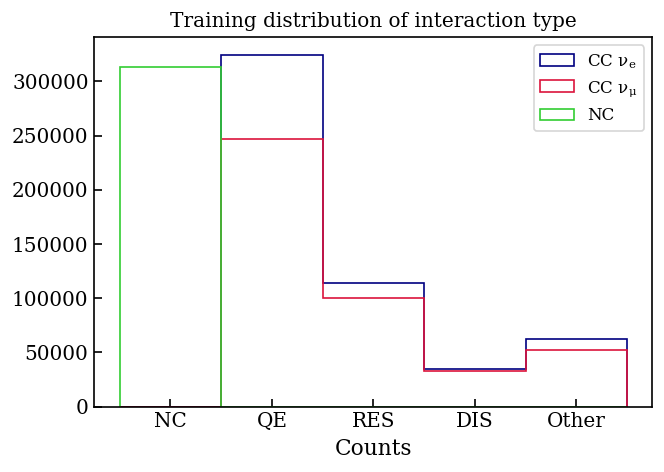

In [89]:
bins = plt.hist(interaction_code[df['flavour']==1], bins=np.arange(-1,5), histtype='step', label='CC $\\nu_e$')
plt.hist(interaction_code[df['flavour']==2], bins=bins[1], histtype='step', label='CC $\\nu_\\mu$')
plt.hist(interaction_code[df['flavour']==0], bins=bins[1], histtype='step', label='NC')
plt.xticks(bins[1][1:]-0.5, ['NC', 'QE', 'RES', 'DIS', 'Other'])
plt.legend()
# plt.yscale('log')
plt.xlabel('Counts')
plt.title('Training distribution of interaction type')
plt.savefig('model_eval_plots/interaction_type_prior_distribution.pdf')
plt.show()